In [148]:
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes
import numpy as np
import xarray as xr
from os.path import join
import reader
import pandas as pd

## Read the data

In [149]:
fname = "/data/jol/sat_data/sar_polar/CovMat.zarr"
ds = reader.read_covar_matrix(fname)
# Write to MATLAB files
# for cm in ds.keys():
#    sio.savemat(f'data/CovMat_{cm}.mat', {'CovMat': ds[k].values})

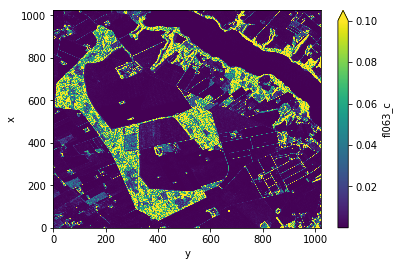

In [3]:
np.flip(np.abs(ds['fl063_c'].isel(m=1, p=1)), axis=0).plot(vmax=.1);

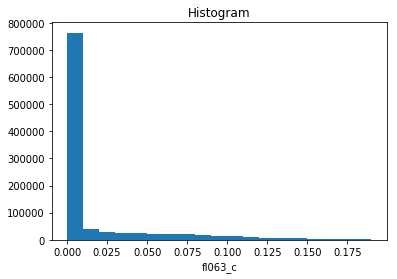

In [103]:
np.abs(ds['fl063_c'].isel(m=1, p=1)).plot.hist(bins=np.arange(0,0.2,0.01));

## Plot the field mask

The mask labels are as follows:

1	Rye <br>
2	Grass (Rajgræs)<br>
3	Winter wheat<br>
4	Grass (Rajgræs)<br>
5	Winter wheat<br>
6	Spring barley<br>
7	Peas<br>
8	Rye<br>
9	Spring oats<br>
10	Grass (Rajgræs)<br>
11	Winter wheat<br>
12	Rye<br>
13	Spring barley<br>
14	Spring barley<br>
15	Peas<br>
16	Grass (Rajgræs)<br>
17	Winter barley<br>
18	Peas<br>
19	Peas<br>
20	Winter wheat<br>
21	Peas<br>
22	Winter wheat<br>
23	Rye<br>
24	Peas<br>
25	Winter barley<br>
26	Grass (Rajgræs)<br>
27	Winter wheat<br>
28	Peas<br>
29	Spring barley<br>
30	Beets<br>
31	Spring barley
32	Grass (slet græs)
33	Winter wheat<br>
34	Spring barley<br>
35	Winter wheat<br>
36	Spring barley<br>
37	Peas<br>

There are only mask for the first 7 so far. 

In [64]:
mask = xr.open_rasterio('data/foulum_mask.tif').squeeze()
mask = xr.DataArray(mask.values, dims=('x', 'y'))
#import scipy.io as sio
#sio.savemat('data/foulum_mask.mat', {'fields': mask.values})

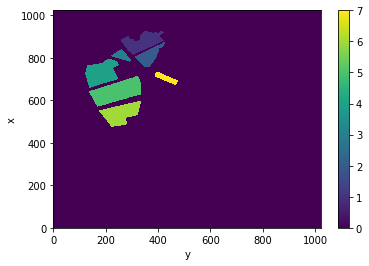

In [65]:
np.flip(mask, axis=0).plot()

## Make RGB plots

fl063_c


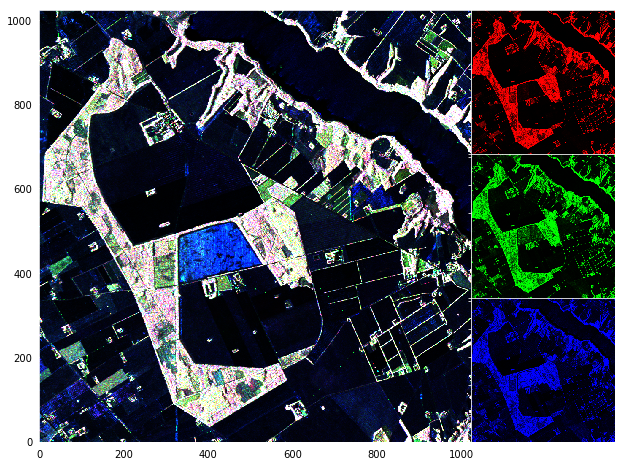

fl063_l


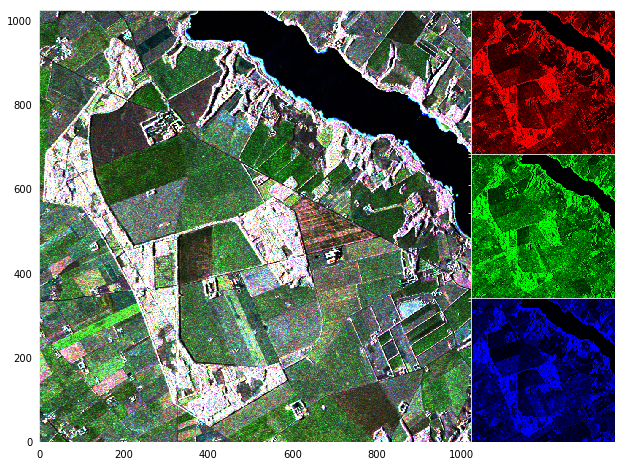

fl064_c


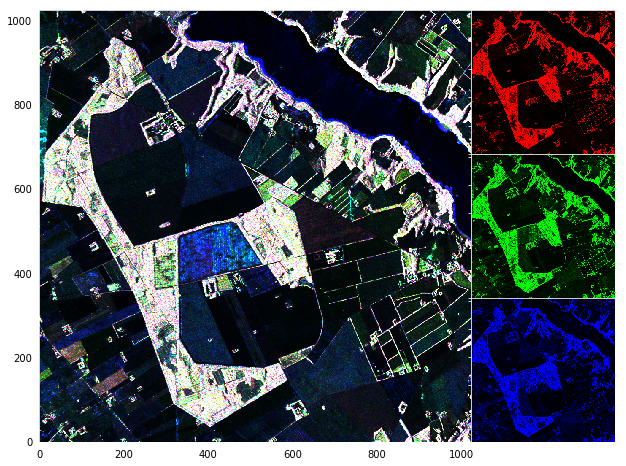

fl064_l


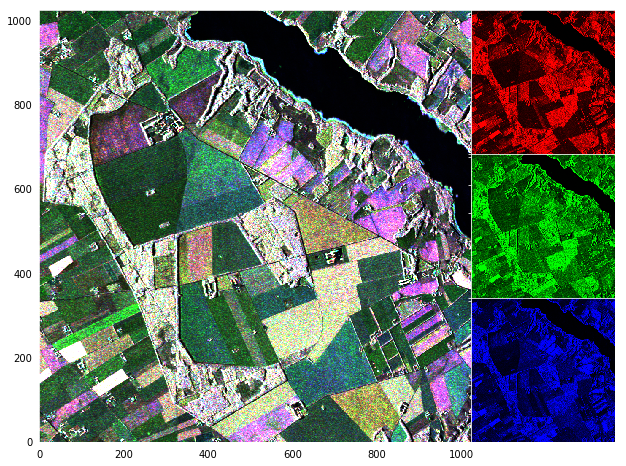

fl065_c


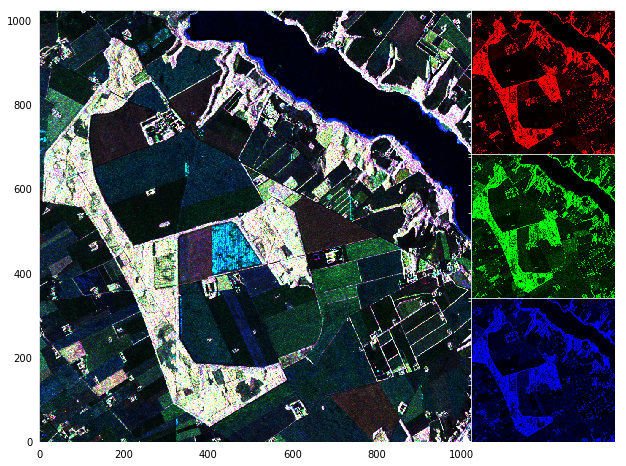

fl065_l


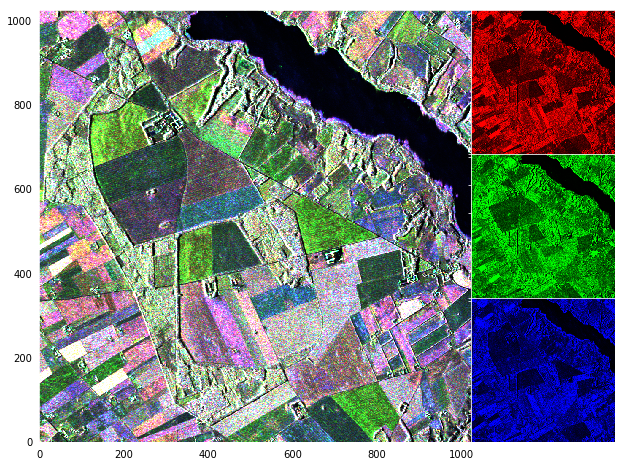

fl068_c


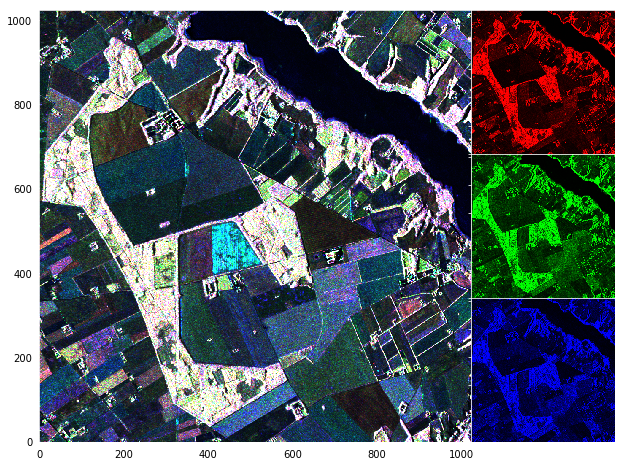

In [168]:
def normalise(c, q=0.90):
    c = np.flip(c.real, axis=0)
    return np.clip(c / np.quantile(c, q), 0, 1)

for v in list(ds.variables):
    da = ds[v]
    r = normalise(da.isel(m=1,p=1))
    g = normalise(da.isel(m=0,p=0))
    b = normalise(da.isel(m=2,p=2))
    
    fig = plt.figure(figsize=(10, 10))
    #fig.text(0.5,0,v)
    ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8])
    print(v)
    ax.imshow_rgb(r, g, b, vmax=.01, **kwargs)
    plt.show()
    #fname = join('/data/jol/sat_data/sar_polar/plots', v + '.png')
    #fig.savefig(fname, tightlayout=True)

## Caculate the ENLs

$\text{ENL} = \frac{E^2}{\sigma^2}$


In [171]:
diag_els = [(0, 0), (1, 1), (2, 2)]
all_els =[(m, p) for m in range(3) for p in range(3)]
def ENLs(field, k):
    for m, p in diag_els:
        db = np.abs(ds[k].where(mask==field).sel(m=m, p=p))
        #np.abs(np.flip(d, axis=0)).plot(vmax=10)
        #plt.title(f"m = {m}, p = {p}")
        #plt.show()
        #amp = 10**(10*np.abs(db))
        E = db.mean()
        Var = db.std()**2
        yield float(E**2/Var)

def get_enls():
    for cov_matrix in ds.variables.keys():
        for field in range(1, 8):
            vals = np.array(list(ENLs(field, cov_matrix))).mean()
            yield field, cov_matrix, vals

In [ ]:
enl_df = pd.DataFrame(list(get_enls()), columns=['field', 'cvm', 'enls'])
enl_df = enl_df.sort_values(by=['cvm', 'field'])
enl_df

In [163]:
enl_df.groupby('cvm').mean()['enls']

cvm
fl063_c    4.830210
fl063_l    9.824097
fl064_c    8.306979
fl064_l    9.522335
fl065_c    7.977004
fl065_l    9.135213
fl068_c    7.791771
Name: enls, dtype: float64

## Average array

In [164]:
ds.groupby_bins('x', bins=np.arange(0,1024,2**3))

## Toolbox for SAR

https://www.orfeo-toolbox.org/CookBook/index_TOC.html